In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import logging
import collections
import sys
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn/pppc')
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn')
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cupy
from skimage.transform import resize

import tike
import tike.ptycho
import tike.view

In [27]:
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.viridis()

<Figure size 640x480 with 0 Axes>

In [28]:
def clean_data(arr):
    mask = arr < 0
    vals = arr[mask]
    vals = 32768 + (vals - -32768)
    arr[mask] = vals
    return arr

In [29]:
scan_idx = 251
save_figs = False
pos_corr = 1
keep_intermediate_states = True
type = 'calculated'
scaling_dict = collections.defaultdict(lambda: 1.0, {236: 0.5, 239: 0.5, 240: 0.25, 241: 0.25, 242: 0.25, 250: 0.5, 251: 0.5, 252: 0.25, 253: 0.25})

In [30]:
f = np.load('data/test{}.npz'.format(scan_idx))
data_raw = f['reciprocal']
try:
    probe_pos_list_true = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32')
    probe_pos_list_true -= np.mean(probe_pos_list_true, axis=0)
except:
    pass
if type == 'calculated':
    probe_pos_list_raw = np.genfromtxt('outputs/test{}/calc_pos_{}_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.csv'.format(scan_idx, scan_idx), delimiter=',').astype('float32')
    #probe_pos_list_raw *= 1.05
elif type == 'true':
    probe_pos_list_raw = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32')
elif type == 'baseline':
    s = scaling_dict = scaling_dict[scan_idx]
    print('Baseline position scaled by {}.'.format(s))
    probe_pos_list_raw = np.genfromtxt('data/pos221.csv', delimiter=',').astype('float32') * s  # Baseline
else:
    raise ValueError
probe_raw = np.load('tike_test/scan221_raw.npz')['probe']
probe_raw = probe_raw[0] + 1j * probe_raw[1]
probe_raw = probe_raw.astype('complex64')[None, :, :]
#probe = np.load('data/probe.npy')

print('data size: ', data_raw.shape)
print('probe size: ', probe_raw.shape)

data size:  (961, 512, 512)
probe size:  (1, 256, 256)


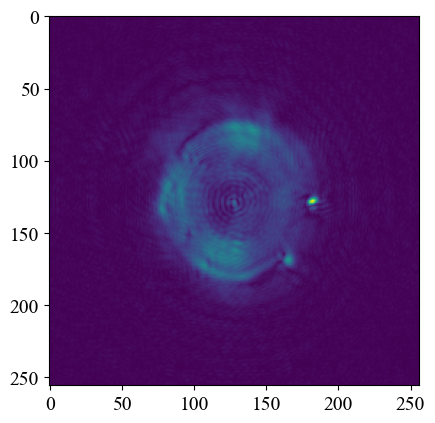

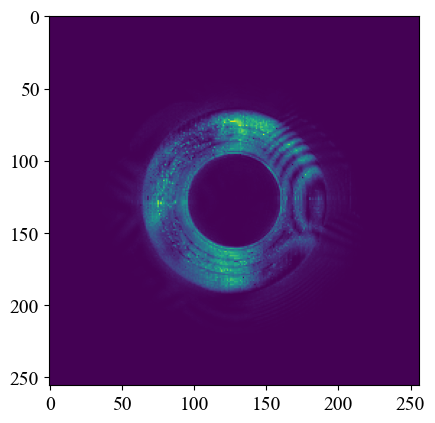

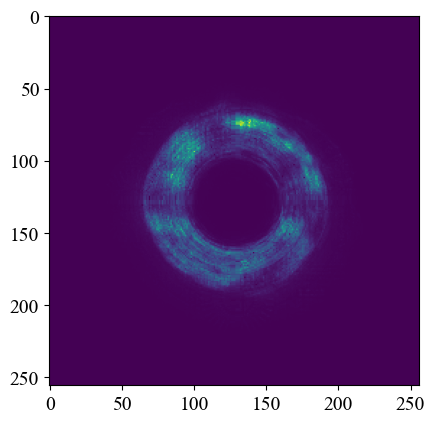

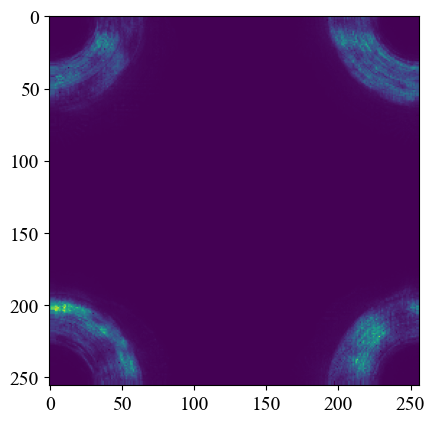

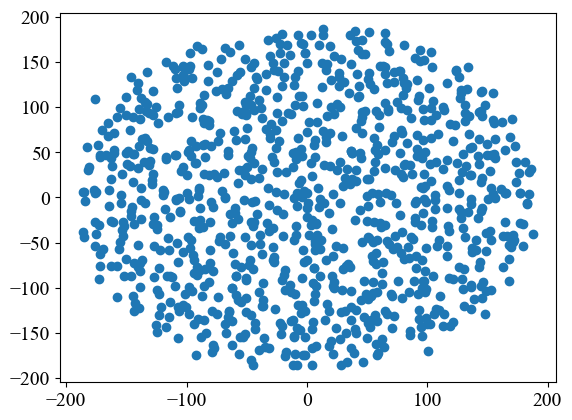

In [31]:
# Data transform:
# Use probe and pixel size in scan221_raw.npz. 
# If DP size is (256, 256), use as it is. (235, 247)
# If DP size is (512, 512), crop it to (256, 256) and flip left-right. 

psize_nm = 7.92

probe_pos_list = probe_pos_list_raw
# probe_pos_list *= -1
# probe_pos_list = probe_pos_list - np.min(probe_pos_list, axis=0)
probe_pos_list = probe_pos_list_raw / (psize_nm * 1e-9)
probe_pos_list = probe_pos_list

data = data_raw
data = clean_data(data)
data = data.astype('float32')
#data = transform_data_for_ptychonn(data, target_shape=(128, 128), discard_len=(64, 64))
#data = transform_data_for_ptychonn(data, target_shape=(128, 128), discard_len=(192, 192))
if data.shape[-1] == 512:
    data = data[:, 128:-128, -128:128:-1]
data = np.fft.fftshift(data, axes=(-1, -2))

probe = probe_raw
#probe_real = transform_data_for_ptychonn(probe.real, target_shape=(256, 256), discard_len=None)
#probe_imag = transform_data_for_ptychonn(probe.imag, target_shape=(256, 256), discard_len=None)
#probe = probe_real + 1j * probe_imag
probe = probe[np.newaxis, np.newaxis, :, :, :]
probe = tike.ptycho.probe.add_modes_random_phase(probe, 1)

plt.imshow(np.abs(probe[0, 0, 0]))
plt.show()
plt.imshow(np.fft.ifftshift(np.abs(np.fft.fft2(probe[0, 0, 0])) ** 2))
plt.show()
plt.imshow(np.fft.ifftshift(data[0]))
plt.show()
plt.imshow(data[0])
plt.show()
plt.scatter(probe_pos_list[:, 1], probe_pos_list[:, 0])

In [32]:
probe.shape, probe_pos_list.shape

((1, 1, 1, 256, 256), (961, 2))

In [33]:
psi, probe_pos_list = tike.ptycho.object.get_padded_object(probe_pos_list, probe, extra=60)
print(psi.shape),

(750, 753)


(None,)

In [34]:
position_options = None
if pos_corr:
    position_options = tike.ptycho.PositionOptions(
        probe_pos_list,
        use_adaptive_moment=False,
        use_position_regularization=True,
        update_magnitude_limit=2,
        transform=tike.ptycho.position.AffineTransform()
    )
    
parameters = tike.ptycho.PtychoParameters(
    # Provide initial guesses for parameters that are updated
    probe=probe,
    scan=probe_pos_list,
    psi=psi,
    probe_options=tike.ptycho.ProbeOptions(), # uses default settings for probe recovery
    object_options=tike.ptycho.ObjectOptions(
        # The object will be updated.
        use_adaptive_moment=True,  # smoothness constraint will use our provided setting
        # other object options will be default values
    ),
    position_options=position_options,
    algorithm_options=tike.ptycho.RpieOptions(
        num_iter=128 if not keep_intermediate_states else 1,
        num_batch=7,
    ),
)

In [35]:
logging.basicConfig(level=logging.INFO)

if keep_intermediate_states:
    for epoch in range(128):
        parameters = tike.ptycho.reconstruct(
            data=data,
            parameters=parameters,
            num_gpu=1
        )
        this_probe_pos = parameters.scan
        this_probe_pos = this_probe_pos - np.mean(this_probe_pos, axis=0)
        plt.figure()
        plt.plot(this_probe_pos)
        plt.plot(probe_pos_list_true)
        plt.show()
    result = parameters
else:
    # returns an updated PtychoParameters object
    result = tike.ptycho.reconstruct(
        data=data,
        parameters=parameters,
        num_gpu=1
    )

INFO:tike.ptycho.ptycho:rpie on 961 - 256 by 256 frames for at most 128 epochs.
INFO:tike.cluster:Clustering method is stripes.
INFO:tike.cluster:Clustering method is wobbly center.
INFO:tike.ptycho.ptycho:Probe rescaled by 110.315813
INFO:tike.ptycho.ptycho:rpie epoch 0


[[[[[-2.9190364 +2.2831726e+00j -1.7081721 +9.4820333e-01j
      0.7602539 +4.7061327e-01j ... -4.3377666 +4.6788878e+00j
     -2.7740643 +5.6584182e+00j -1.9538369 +4.0694232e+00j]
    [ 0.5558965 +1.8357887e+00j  0.88261056-1.3748436e+00j
      4.064815  -4.9977212e+00j ... -0.8769542 +3.4817610e+00j
      0.43549752+5.4315090e+00j  0.75493103+5.2658677e+00j]
    [ 1.970542  -5.9847176e-01j  0.5426688 -3.6192708e+00j
      2.8219814 -4.4611773e+00j ...  4.5435925 +2.4916394e+00j
      3.6609983 +5.5967684e+00j  2.9569626 +3.1940084e+00j]
    ...
    [-1.0219393 -9.2779999e+00j  2.743547  -6.2718239e+00j
      2.1064944 -2.0664930e-03j ...  5.4617968 -1.8102016e+00j
      1.375944  -7.0584965e+00j -3.0049934 -8.9135876e+00j]
    [-1.7540388 -4.4769192e+00j  0.49578714+5.2312636e-01j
      0.7692182 +7.2446823e+00j ...  1.3380483 -6.1731398e-01j
     -0.6532686 -4.7507901e+00j -3.4247458 -6.0273743e+00j]
    [-2.3733413 +1.1069012e-01j -1.1939299 +4.0303226e+00j
     -2.072617  +7.2564

INFO:tike.ptycho.ptycho:The object update mean-norm is 3.135e-02
INFO:tike.ptycho.ptycho:  gaussian cost is +8.017e+01


[[[[[ 9.38029140e-02+1.0821171j   2.99511862e+00-1.1372733j
      1.33755696e+00-2.6980834j  ... -3.92144346e+00+2.8251333j
     -4.70502186e+00+4.0658665j  -3.40669179e+00+1.7119017j ]
    [ 1.70356452e+00-1.5054096j   2.17051578e+00-2.5885155j
      2.30139256e+00-2.6094894j  ... -5.46440005e-01+0.07807073j
     -8.59409094e-01+1.3023171j   1.98812008e-01+1.7843012j ]
    [ 1.04352033e+00-1.7152517j   5.37093639e-01-1.8576918j
      2.50877357e+00-0.4041795j  ...  2.41103220e+00-0.47280133j
      3.59994626e+00+0.35741687j  1.17562461e+00+0.14985493j]
    ...
    [-4.35507894e-01-3.567604j    5.28201222e-01-1.9746019j
     -6.04243398e-01+0.42050096j ...  1.17254472e+00-1.0627356j
      1.28853083e+00-3.9820232j   2.22351313e-01-4.0456657j ]
    [-6.23016238e-01-1.6434526j  -3.44828367e-02-1.6085525j
      7.83435404e-02+2.5131366j  ...  6.33014143e-01+0.8968631j
     -5.91803730e-01+0.46607974j -2.18527246e+00+0.11225575j]
    [-1.65596652e+00+1.555768j    1.54153323e+00-0.50186896j

INFO:tike.ptycho.ptycho:rpie epoch 1


[[[[[ 1.29461396e+00+2.1177468j  -9.83456135e-01+1.465701j
     -1.98222423e+00-0.5143816j  ... -2.39397335e+00+1.5489143j
      3.47900152e-01+2.8523152j   7.11970448e-01+3.1073833j ]
    [ 9.14305389e-01+1.3887945j  -1.60774589e-01+0.78593045j
      4.99874711e-01-2.2486527j  ... -1.09630454e+00-0.41767704j
     -1.10906565e+00+2.382039j    1.07085764e+00+2.307384j  ]
    [-3.78105164e-01-0.03223777j  1.05036783e+00-1.2052375j
      1.26141453e+00-2.03554j    ...  1.59590554e+00-0.28095874j
     -1.59537077e-01+1.5094756j   3.37145805e-01+0.13976866j]
    ...
    [-1.02143383e+00-4.497258j    3.30913925e+00-2.6730301j
      2.94513202e+00-0.90411615j ...  8.07947874e-01-0.55725294j
     -2.19922447e+00-3.1899233j  -2.31556916e+00-3.8141098j ]
    [-7.72882104e-01-1.7286685j   4.64706719e-01-0.75926554j
      8.46284091e-01+1.0795627j  ...  4.10705805e-02+0.74320006j
     -5.34311652e-01-0.89222795j -2.13701534e+00-2.3668203j ]
    [ 9.92143035e-01+1.1870441j  -9.96059775e-01+1.107760

INFO:tike.ptycho.ptycho:The object update mean-norm is 4.541e-02
INFO:tike.ptycho.ptycho:  gaussian cost is +3.329e+01
INFO:tike.ptycho.ptycho:rpie epoch 2


[[[[[ 1.1841497 +0.9863728j   3.9742393 -1.2589701j
      1.4820662 -2.9850404j  ... -3.1723027 +1.5988731j
     -3.9610372 +2.8743432j  -2.7196157 +0.95033455j]
    [ 1.7684118 -2.0963879j   2.0772696 -2.7114851j
      1.0353255 -1.7838545j  ... -0.6330285 -0.24826556j
     -0.96773696+0.49777135j -0.07669294+0.922996j  ]
    [ 0.66300744-1.9354343j  -0.10046518-1.2049764j
      0.90179926+0.6767976j  ...  0.84305096-0.30121493j
      2.5371757 -0.3721155j   0.5777353 -0.32543814j]
    ...
    [-0.9360816 -1.66803j    -0.54956746-0.68900526j
     -0.8092278 +0.7034401j  ...  0.10479549-0.16734493j
      0.8141125 -2.1223779j  -0.02512825-2.180329j  ]
    [-0.4729561 -0.25005734j -0.28128824-1.7798147j
      0.17358246+0.7470337j  ...  0.44672993+0.8971039j
     -0.12587991+0.9194102j  -1.5580099 +1.2162176j ]
    [-0.8506416 +1.6668906j   1.9549335 -1.2161269j
      1.3448123 -0.6776204j  ... -2.1695287 +1.6793362j
     -2.584573  +3.4997938j  -3.0060103 +2.5297575j ]]]]



 [[[[-0.96

INFO:tike.ptycho.ptycho:The object update mean-norm is 5.315e-02
INFO:tike.ptycho.ptycho:  gaussian cost is +2.560e+01
INFO:tike.ptycho.ptycho:rpie epoch 3


[[[[[-7.93270946e-01-2.1703231e-01j -1.40407944e+00-9.1684169e-01j
     -4.75336075e-01+8.6013049e-02j ... -9.91595268e-01-4.2921165e-01j
      8.83210242e-01+6.5806031e-02j  1.16414189e+00+1.1143142e+00j]
    [ 1.03678656e+00-1.6212244e+00j  7.96730220e-01-2.2640233e+00j
      7.28555322e-01-4.9182928e-01j ... -7.75856972e-02+2.7278066e-01j
      3.97540689e-01+2.2427540e+00j  4.46995497e-02+1.7475489e+00j]
    [ 1.79694402e+00-5.1195991e-01j  1.56923461e+00-5.6838059e-01j
      1.69670177e+00+8.0535412e-02j ...  2.91823208e-01+2.0248117e+00j
     -1.45495546e+00+3.1812720e+00j -1.36900067e-01+1.2961040e+00j]
    ...
    [-8.38309526e-02-9.9069852e-01j  1.01375842e+00-6.6539294e-01j
      5.94104409e-01-2.6715362e-01j ...  4.71563041e-01+1.2752461e+00j
     -1.49431467e+00+1.3582781e-01j -1.90405607e+00-1.9160638e+00j]
    [-9.57280397e-02-3.5995811e-02j  9.52005565e-01+8.5144615e-01j
      7.73686230e-01+3.3244354e-01j ...  8.92594337e-01+1.2884133e+00j
      7.89116979e-01-2.4186969


KeyboardInterrupt



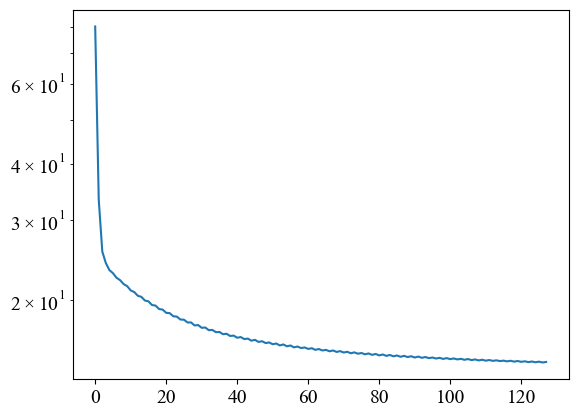

In [12]:
fig = plt.figure()
avg_cost = np.mean(np.stack(result.algorithm_options.costs, axis=0), axis=1)
plt.semilogy(avg_cost)
pos_corr_str = 'posCorr_1_clip_2' if pos_corr else 'posCorr_0'
if save_figs:
    if type == 'calculated':
        fig.savefig(os.path.join('outputs/test{}/loss_history_calc_pos_{}.pdf'.format(scan_idx, pos_corr_str)))
        np.savetxt(os.path.join('outputs/test{}/loss_history_calc_pos_{}.txt'.format(scan_idx, pos_corr_str)), avg_cost)
    elif type == 'true':
        fig.savefig(os.path.join('outputs/test{}/loss_history_true_pos.pdf'.format(scan_idx)))
        np.savetxt(os.path.join('outputs/test{}/loss_history_true_pos.txt'.format(scan_idx)), avg_cost)
    elif type == 'baseline':
        fig.savefig(os.path.join('outputs/test{}/loss_history_baseline_pos_{}.pdf'.format(scan_idx, pos_corr_str)))
        np.savetxt(os.path.join('outputs/test{}/loss_history_baseline_pos_{}.txt'.format(scan_idx, pos_corr_str)), avg_cost)
    else:
        raise ValueError
else:
    plt.show()


(0.13713914-0.10156092j) (1.0789521+0.5550947j)


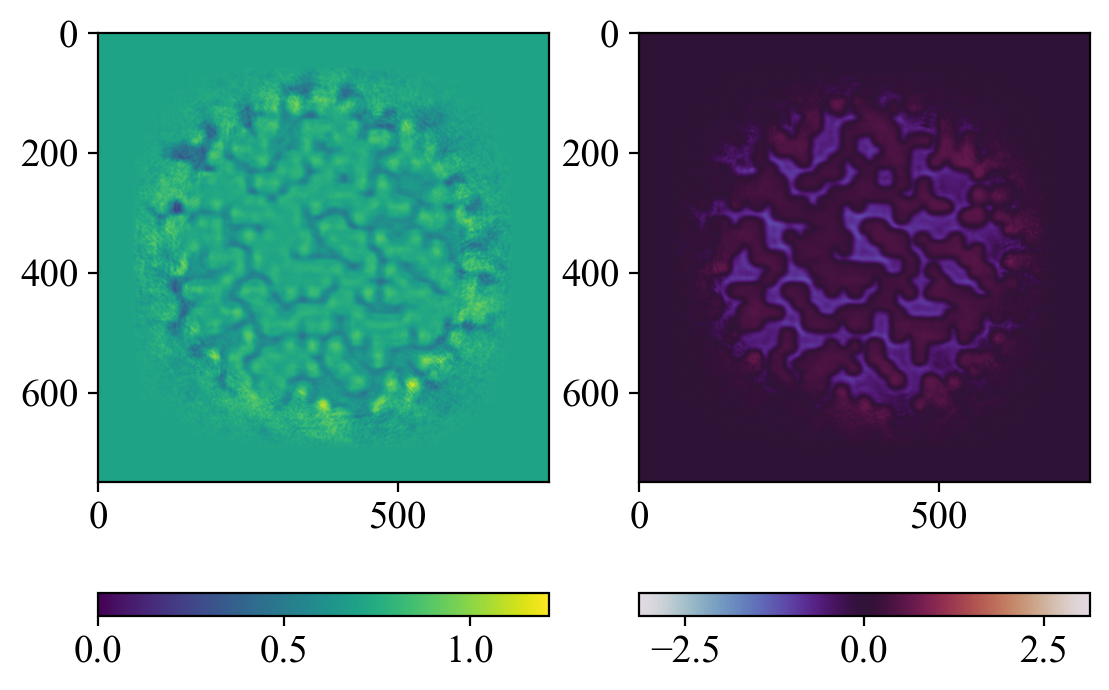

In [13]:
plt.figure(dpi=200)
tike.view.plot_phase(result.psi, amin=0)
plt.show()

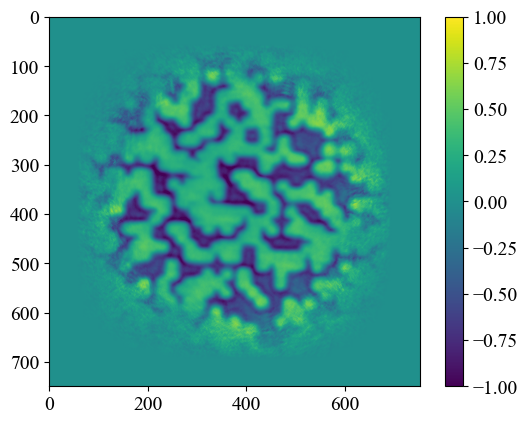

In [14]:
fig = plt.figure()
im = plt.imshow(np.angle(result.psi), vmin=-1, vmax=1)
plt.colorbar(im)
pos_corr_str = 'posCorr_1_clip_2' if pos_corr else 'posCorr_0'
if save_figs:
    if type == 'calculated':
        fig.savefig('outputs/test{}/rpie_{}_pos_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.pdf'.format(scan_idx, pos_corr_str))
    elif type == 'true':
        fig.savefig('outputs/test{}/rpie_posCorr_0_pos_true.pdf'.format(scan_idx))
    elif type == 'baseline':
        fig.savefig('outputs/test{}/rpie_{}_pos_baseline.pdf'.format(scan_idx, pos_corr_str))
    else:
        raise ValueError
else:
    plt.show()

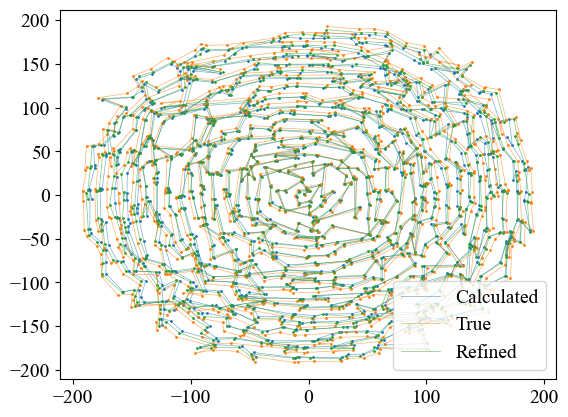

In [15]:
probe_pos_list_calc = probe_pos_list
probe_pos_list_true = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32') / (psize_nm * 1e-9)
probe_pos_list_refined = result.scan
probe_pos_list_calc -= np.mean(probe_pos_list_calc, axis=0)
probe_pos_list_true -= np.mean(probe_pos_list_true, axis=0)
probe_pos_list_refined -= np.mean(probe_pos_list_refined, axis=0)
# probe_pos_list_raw *= 1.05
plt.scatter(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], s=1)
plt.scatter(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], s=1)
plt.scatter(probe_pos_list_refined[:, 1], probe_pos_list_refined[:, 0], s=1)
plt.plot(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], linewidth=0.5, alpha=0.6, label='Calculated')
plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=0.5, alpha=0.6, label='True')
plt.plot(probe_pos_list_refined[:, 1], probe_pos_list_refined[:, 0], linewidth=0.5, alpha=0.6, label='Refined')
plt.legend()
if save_figs and type == 'calculated' and pos_corr:
    plt.savefig('outputs/test{}/comparison_path_plot_true_calc_refined_clip_2_collective_iter_2_nn_12_sw_1e-3_1e-2.pdf'.format(scan_idx))
else:
    plt.show()

In [17]:
import copy
result_old = copy.deepcopy(result)

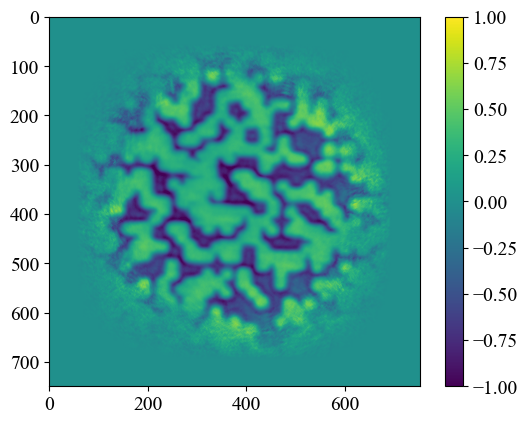

In [18]:
fig = plt.figure()
im = plt.imshow(np.angle(result_old.psi), vmin=-1, vmax=1)
plt.colorbar(im)